# DS/CMPSC 410 Spring 2021
# Instructor: Professor John Yen
# TA: Rupesh Prajapati 
# LAs: Lily Jakielaszek and Cayla Shan Pun
# Lab 10 (bonus) Recurrent Neural Networks

## The goals of this lab are for you to be able to
### - Use tensorflow and keras to implement an RNN for time series prediction 
### - Be able to prepare a time series data for training and testing.
### - Be able to design the normalization and sliding window size for forecasting 
### - Be able to normalize a time series using min-max scaling 
### - Be able to compare the learning outcomes of a simple RNN with and without normalization
### - Be able to decide the number of epochs needed for training

## Exercises: 
- Exercise 1: 5 points
- Exercise 2: 10 points
- Exercise 3: 10 points
- Exercise 4: 10 points
- Exercise 5: 10 points
- Exercise 6: 15 points
- Exercise 7: 10 ponts
- Exercise 8: 10 points
- Exercise 9: 10 points
- Exercise 10: 10 points

## Total Points (Lab): 100 points (bonus, as described in the Canvas Announcement)

# Due: midnight, April 29 (Friday), 2022

# Install tensorflow and keras
The first thing to do is to install tensorflow and keras in your ICDS Roar environment.
- Open a terminal window in Jupyter Lab
- Type the following in ther terminal window 
```pip install tensorflow```
- After the installation of tensorflow completes, type the following in the terminal window 
```pip install keras```
- Wait until the installation completes. Then run the "import tensorflow as tf" in Jupyter Notebook and continue based on the instructions on Jupyter Notebook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *

In [2]:
import pyspark

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.clustering import KMeans

In [4]:
import matplotlib.pyplot as plt

# Data for Time Series Prediction
### This lab uses an hourly energy consumption data from Kaggle
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
### The file AEP_hourly.csv contains hourly energy consumption from American Eletric Power (AEP).
### The original source of the data is PJM Interconnection LLC (PJM), which is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

In [5]:
ss = SparkSession.builder.master("local").appName("Lab 10 RNN").getOrCreate()

# Exercise 1 ( 5 points )
Enter your name and update the path below to your directory for the lab.

## Answer to Exercise 1
Your Name: Haichen Wei

In [6]:
AEP_hourly_df = ss.read.csv("/storage/home/hxw5245/Lab10/AEP_hourly.csv", header=True, inferSchema=True)

In [7]:
AEP_hourly_df.printSchema()

root
 |-- Datetime: string (nullable = true)
 |-- AEP_MW: double (nullable = true)



In [8]:
AEP_hourly_df.show(3)

+-------------------+-------+
|           Datetime| AEP_MW|
+-------------------+-------+
|2004-12-31 01:00:00|13478.0|
|2004-12-31 02:00:00|12865.0|
|2004-12-31 03:00:00|12577.0|
+-------------------+-------+
only showing top 3 rows



# Part A: Prepare a Min-Max Scaling Function

## One way to obtain the maximum value of a column of PySpark DataFrame is to use aggregation fuction. The `agg()` sql function can be used to calculate min, max, average, sum, etc directly on a column of a DataFrame or after a GroupBy. To apply `agg` to a column, it takes a `dictionary` that maps a column name to the name (string) of an aggregation function.

## Reminder: A `dictionary` in Python is expressed as `{ <key> : <value> }`. In this case, the key is a column name, and the value is the name of an aggregation function (e.g., max, min, etc)

In [9]:
max_df = AEP_hourly_df.agg({'AEP_MW': 'max'})

In [10]:
max_df.show()

+-----------+
|max(AEP_MW)|
+-----------+
|    25695.0|
+-----------+



In [11]:
max_AEP_list = max_df.rdd.map(lambda x: x[0]).collect()

In [12]:
max_AEP_list

[25695.0]

In [13]:
max_AEP = max_AEP_list[0]

## We use a similar procedure to find the minimum value of the `AEP_MW` column.

In [14]:
min_df = AEP_hourly_df.agg({'AEP_MW': 'min'})

In [15]:
min_df.show()

+-----------+
|min(AEP_MW)|
+-----------+
|     9581.0|
+-----------+



In [16]:
min_AEP_list = min_df.rdd.map(lambda x: x[0]).collect()

In [17]:
min_AEP_list

[9581.0]

In [18]:
min_AEP = min_AEP_list[0]

## We define a function for scaling a value, which is between min and max, to a number between 0 and 1. 

In [19]:
def min_max_scale (x, min, max):
    return ((x-min)/(max-min))

## Similarly, we define a function for inverse mapping, which is to map a number between 0 and 1 to a number between min and max.

In [20]:
def inverse_min_max_scale (s, min, max):
    return (min + s*(max-min))

## A simple test to see whether the two functions are correct for scaling a number between min_AEP and max_AEP.

In [21]:
# The test value needs to be between min_AEP and max_AEP
x = 10000
s = min_max_scale(x, min_AEP, max_AEP)

In [22]:
inv = inverse_min_max_scale (s, min_AEP, max_AEP)

In [23]:
print(" s = ", s, "inverse of s =", inv)

 s =  0.026002234082164576 inverse of s = 10000.0


# Part B Convert Time Series Data into a list. Visualize and normalize the series. 
## We will use both the original time series and the normalized time series later in this lab so that we can compare the results of RNN learning on these two input data.  
### Part D and E will use the original time series.
### Part F and G will use the normalized time series.

In [24]:
AEP_hourly_df

DataFrame[Datetime: string, AEP_MW: double]

In [25]:
time_series_df = AEP_hourly_df.select(col("AEP_MW"))

In [26]:
time_series_rdd = time_series_df.rdd

In [27]:
time_series_rdd.take(3)

[Row(AEP_MW=13478.0), Row(AEP_MW=12865.0), Row(AEP_MW=12577.0)]

In [28]:
time_series2_rdd = time_series_rdd.map(lambda row: row[0])

In [29]:
time_series2_rdd.take(3)

[13478.0, 12865.0, 12577.0]

## Convert the Time Series data from RDD to a list.

In [30]:
AEP_tsd_list = time_series2_rdd.collect()

## In the beginning of this notebook, we imported `matplotlib.pyplot` as `plt`. Therefore, we can plot the time series using `plt` below. The code below plots the first 300 hours of the time series data.

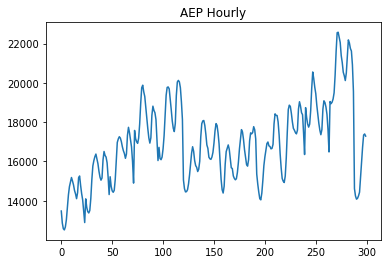

In [31]:
plt.title('AEP Hourly')
plt.plot(AEP_tsd_list[:300])
plt.show()

# Normalize the time series using min_max scaling.

# Exercise 2 (10 points)
## Complete the code below to generate a plot for normalized time series data. Note: We will use norm_AEP_tsd_list later in this lab (Part F and G). 

In [32]:
norm_AEP_tsd_rdd = time_series2_rdd.map(lambda x: min_max_scale(x, min_AEP, max_AEP))

In [33]:
norm_AEP_tsd_list= norm_AEP_tsd_rdd.collect()

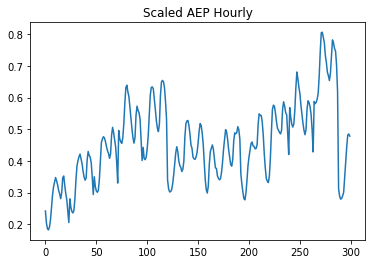

In [34]:
plt.title('Scaled AEP Hourly')
plt.plot(norm_AEP_tsd_list[:300])
plt.show()

# Part C Split the original time series data into two: a training set (earlier time), and a testing set (later time)
## We will first determine the size of training set (90% of data) and testing/validation set (10%).

In [35]:
data_size = len(AEP_tsd_list)

In [36]:
print(data_size)

121273


In [37]:
training_size = int(data_size *0.9)

In [38]:
testing_size = data_size - training_size

In [39]:
time_series_list = AEP_tsd_list

## Divide the original time series data in training and testing (for Part D)
### In Part F, we will do the similar spliting on the normalized time series data.

In [40]:
training_tsd = AEP_tsd_list[0:training_size]

In [41]:
test_tsd = AEP_tsd_list[training_size:data_size]

# Part D Create Training and Testing Data Using Original (Not Normalized) Time Series.

## We will use 200 hours as the length of the input sliding window to predict the energy consumption of the next hour.
## Each training data instance consists of 200 features (i.e., energy consumption of 200 consecutive hours), and 1 output value (i.e., energy consumption of the 201th hour from the beginning of input sliding window).
### Design Rationale: We chose 200 hours because energy consumption of weekends and weekdays differ. Therefore, it makes sense to have the sliding window covers at least previous 7 days, which is 168 (24*7) hours.

### We will use Pandas dataframe to store input features and output for the training data and testing data.
### First, we create a list of column names for the Panda dataframe to be used to store training instances and testing instances.

In [42]:
column_names = []
# input_length is the length of the time series to be used for prediction
input_length = 200 
for i in range(0, input_length):
    columna_names = column_names.append("hour_"+str(i))

In [43]:
# Divide the training_tsd into length of 201, using 200 hourly data to predict the next hourly energy consumption
training_input_df = pd.DataFrame( columns=[ column_names ] )
training_output_df = pd.DataFrame( columns= [ "forecast"] )
output_time = 1
total_length = input_length + output_time
remaining_tsd2 = training_tsd
index = 0
for i in range(0, training_size, total_length):
    remaining_tsd = remaining_tsd2
    begin = 0 
    input_end = begin + input_length
    output_end = input_end + output_time
    if len(remaining_tsd) >= total_length:
        for j in range(0, input_length):
            column_name = "hour_"+str(j)
            training_input_df.loc[index,column_name]= remaining_tsd[begin+j]
        training_output_df.loc[index] = remaining_tsd[output_end-1]
        index= index +1
        remaining_tsd2 = remaining_tsd[output_end:]

In [44]:
training_input_df

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_190,hour_191,hour_192,hour_193,hour_194,hour_195,hour_196,hour_197,hour_198,hour_199
0,13478,12865,12577,12517,12670,13038,13692,14297,14719,14941,...,17618,17147,15358,14851,14441,14105,14048,14394,15034,15783
1,16576,16912,16991,16793,16764,16643,16666,16869,17916,18424,...,20491,20295,19843,19422,19050,18519,18301,17748,17696,18153
2,20441,20502,20486,20274,19304,18139,16704,16281,16064,16155,...,15782,16935,17249,17045,16958,16499,15426,14223,13563,13318
3,13239,13556,14605,16104,17348,17211,17212,17260,17153,16879,...,12292,12015,11934,12077,12253,12690,13423,14082,14509,14606
4,14567,14565,14347,14318,14675,15910,16406,16582,16447,16162,...,14419,14392,14137,13920,13714,13581,13854,14598,14640,14316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,14639,15264,15506,15496,15311,14978,14402,13483,13469,13267,...,15114,14938,15090,15840,16138,16156,16077,15816,15212,14506
539,14379,14447,14471,14804,15610,16906,17429,17115,16596,16177,...,14735,12628,12578,12510,12639,13081,13870,15199,15967,16007
540,16102,15966,15761,15840,15720,15644,15808,16427,16510,16445,...,11424,12029,12388,12409,12509,12614,12526,12525,12406,12581
541,13452,13325,13059,12576,11985,11441,11587,11296,11100,10984,...,13319,13472,13704,13945,13700,13336,12898,12369,12388,12223


## We need to convert the Pandas dataframe to numpy array.
### The shape of RNN input is `(<number of training instances>, <size of sliding window>, <number of output>)`
### Because the output of our prediction problem is 1, we need to reshape the training data using `np.reshape`.

In [45]:
training_input_array = training_input_df.to_numpy()

In [46]:
training_input_array.shape

(543, 200)

In [47]:
training_input_array2= np.reshape(training_input_array, [543, 200, 1])

In [48]:
training_input_array2.shape

(543, 200, 1)

## Similarly, we convert the Pandas dataframe for training output to numpy array.

In [49]:
training_output_array = training_output_df.to_numpy()

In [50]:
training_output_array.shape

(543, 1)

### Note: We still do a reshape here on the training ouput. Even though it is not needed in this case, it may be needed in other cases.

In [51]:
training_output_array2=np.reshape(training_output_array, [543, 1])

## We create testing input and testing output data in a similar way.
### Reminder: The time series of testing data, generated earlier in Part C, is `test_tsd`.

# Exercise 3 (10 points)
Complete the code below for generating testing data instances using Pandas dataframe.

In [52]:
testing_size

12128

In [53]:
# Divide the testing_tsd into length of 201, using 200 hourly data to predict the next hourly energy consumption
testing_input_df = pd.DataFrame( columns=[ column_names ] )
testing_output_df = pd.DataFrame( columns= [ "forecast"] )
input_length = 200
output_time = 1
total_length = input_length + output_time
remaining_tsd2 = test_tsd
index = 0
# Set up these three constants to be used in the for loop
begin=0
input_end = begin + input_length
output_end = input_end + output_time
for i in range(0, testing_size, total_length):
    remaining_tsd = remaining_tsd2
    if len(remaining_tsd) >= total_length:
        for j in range(0, input_length):
            column_name = "hour_"+str(j)
            testing_input_df.loc[index,column_name]= remaining_tsd[begin+j]
        testing_output_df.loc[index] = remaining_tsd[output_end-1]
        index= index +1
        remaining_tsd2 = remaining_tsd[output_end:]

## Like testing data, we convert the Pandas dataframe to np array, then reshape it into the shape expected by RNN.

In [54]:
testing_input_array = testing_input_df.to_numpy()

In [55]:
testing_output_array = testing_output_df.to_numpy()

In [56]:
testing_input_array.shape

(60, 200)

In [57]:
testing_input_array2 = np.reshape( testing_input_array, [60, 200, 1] )

In [58]:
testing_input_array2.shape

(60, 200, 1)

In [59]:
testing_output_array2 = np.reshape( testing_output_array, [60, 1] )

In [60]:
testing_output_array2.shape

(60, 1)

# Part E RNN Learning for Original Time Series
# We build an RNN using a type of keras layer: SimpleRNN

In [61]:
model2 = tf.keras.Sequential( [ \
                             tf.keras.layers.SimpleRNN(200), \
                              ])

## Notice the loss function is MeanSquredError because the output is a number, not a category (like hand written chracter recognition problem in Lab 9).

In [62]:
model2.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())

## The final data preparation is to convert the training input/output, testing input/output to tensors of `float32` data type, which is what is expected in RNN.

In [63]:
training_input_tensor = tf.convert_to_tensor(training_input_array2, dtype=tf.float32)

In [64]:
training_output_tensor = tf.convert_to_tensor(training_output_array2, dtype=tf.float32)

In [65]:
testing_input_tensor = tf.convert_to_tensor(testing_input_array2, dtype=tf.float32)

In [66]:
testing_output_tensor = tf.convert_to_tensor(testing_output_array2, dtype=tf.float32)

# Finally, we can run RNN on the training and testing tensor. We will use a batch size of 256, maximum epochs of 30.

In [67]:
model2.fit(training_input_tensor, training_output_tensor, batch_size=256, epochs=30, verbose=1, \
           validation_data = (testing_input_tensor, testing_output_tensor) )

Epoch 1/30
3/3 [==============================] - 2s 370ms/step - loss: 243903952.0000 - val_loss: 220069648.0000
Epoch 2/30
3/3 [==============================] - 1s 191ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 3/30
3/3 [==============================] - 1s 189ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 4/30
3/3 [==============================] - 1s 193ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 5/30
3/3 [==============================] - 1s 192ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 6/30
3/3 [==============================] - 1s 192ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 7/30
3/3 [==============================] - 1s 190ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 8/30
3/3 [==============================] - 1s 188ms/step - loss: 243903648.0000 - val_loss: 220069648.0000
Epoch 9/30
3/3 [==============================] - 1s 191ms/step - loss: 243903648.0000 -

# Part F Create Training and Testing Data Using Normalized Time Series.

### Like Part D, we will use 200 hours as the length of the input sliding window to predict the energy consumption of the next hour. Each training data instance consists of 200 features (i.e., energy consumption of 200 consecutive hours), and 1 output value (i.e., energy consumption of the 201th hour from the beginning of input sliding window). Design Rationale: We chose 200 hours because energy consumption of weekends and weekdays differ. Therefore, it makes sense to have the sliding window covers at least previous 7 days, which is 168 (24*7) hours.

## Divide the NORMALIZED time series data in training and testing 
## To avoid confusion with variables in Part D and E, we will add "n" in the front of each variable (except temporary variables in the loop).
## Reminding: We have created, toward the end of Part C, normlized AEP time series: `norm_AEP_tsd_list`

In [68]:
n_training_tsd = norm_AEP_tsd_list[0:training_size]

In [69]:
n_test_tsd = norm_AEP_tsd_list[training_size:data_size]

In [70]:
column_names = []
# input_length is the length of the time series to be used for prediction
input_length = 200 
for i in range(0, input_length):
    columna_names = column_names.append("hour_"+str(i))

In [71]:
# Divide the normalized n_training_tsd into length of 201, using 200 hourly data to predict the next hourly energy consumption
n_training_input_df = pd.DataFrame( columns=[ column_names ] )
n_training_output_df = pd.DataFrame( columns= [ "forecast"] )
output_time = 1
total_length = input_length + output_time
remaining_tsd2 = n_training_tsd
index = 0
for i in range(0, training_size, total_length):
    remaining_tsd = remaining_tsd2
    begin = 0 
    input_end = begin + input_length
    output_end = input_end + output_time
    if len(remaining_tsd) >= total_length:
        for j in range(0, input_length):
            column_name = "hour_"+str(j)
            n_training_input_df.loc[index,column_name]= remaining_tsd[begin+j]
        n_training_output_df.loc[index] = remaining_tsd[output_end-1]
        index= index +1
        remaining_tsd2 = remaining_tsd[output_end:]

In [72]:
n_training_input_df

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_190,hour_191,hour_192,hour_193,hour_194,hour_195,hour_196,hour_197,hour_198,hour_199
0,0.241839,0.203798,0.185925,0.182202,0.191697,0.214534,0.25512,0.292665,0.318853,0.33263,...,0.498759,0.46953,0.358508,0.327045,0.301601,0.28075,0.277212,0.298684,0.338401,0.384883
1,0.434095,0.454946,0.459849,0.447561,0.445761,0.438252,0.43968,0.452278,0.517252,0.548777,...,0.677051,0.664888,0.636838,0.610711,0.587626,0.554673,0.541144,0.506826,0.503599,0.53196
2,0.673948,0.677734,0.676741,0.663584,0.603388,0.531091,0.442038,0.415788,0.402321,0.407968,...,0.384821,0.456373,0.47586,0.4632,0.457801,0.429316,0.362728,0.288072,0.247114,0.23191
3,0.227008,0.24668,0.311779,0.404803,0.482003,0.473501,0.473563,0.476542,0.469902,0.452898,...,0.168239,0.151049,0.146022,0.154896,0.165819,0.192938,0.238426,0.279322,0.305821,0.311841
4,0.30942,0.309296,0.295768,0.293968,0.316123,0.392764,0.423545,0.434467,0.426089,0.408403,...,0.300236,0.29856,0.282736,0.269269,0.256485,0.248231,0.265173,0.311344,0.313951,0.293844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0.313889,0.352675,0.367693,0.367072,0.355591,0.334926,0.299181,0.24215,0.241281,0.228745,...,0.343366,0.332444,0.341877,0.38842,0.406913,0.40803,0.403128,0.386931,0.349448,0.305635
539,0.297754,0.301973,0.303463,0.324128,0.374147,0.454574,0.48703,0.467544,0.435336,0.409333,...,0.319846,0.18909,0.185987,0.181767,0.189773,0.217202,0.266166,0.348641,0.396301,0.398784
540,0.404679,0.396239,0.383517,0.38842,0.380973,0.376257,0.386434,0.424848,0.429999,0.425965,...,0.114373,0.151918,0.174196,0.1755,0.181705,0.188221,0.18276,0.182698,0.175313,0.186174
541,0.240226,0.232345,0.215837,0.185863,0.149187,0.115428,0.124488,0.106429,0.0942659,0.0870671,...,0.231972,0.241467,0.255864,0.27082,0.255616,0.233027,0.205846,0.173017,0.174196,0.163957


### Like in Part D, we need to convert the Pandas dataframe to numpy array. The shape of RNN input is `(<number of training instances>, <size of sliding window>, <number of output>)`. Because the output of our prediction problem is 1, we need to reshape the training data using `np.reshape`.

In [73]:
n_training_input_array = n_training_input_df.to_numpy()

In [74]:
n_training_input_array.shape

(543, 200)

In [75]:
n_training_input_array2= np.reshape(n_training_input_array, [543, 200, 1])

In [76]:
n_training_input_array2.shape

(543, 200, 1)

## Similarly, we convert the Pandas dataframe for training output to numpy array.

In [77]:
n_training_output_array = n_training_output_df.to_numpy()

In [78]:
n_training_output_array.shape

(543, 1)

### Note: We still do a reshape here on the training ouput. Even though it is not needed in this case, it may be needed in other cases.

In [79]:
n_training_output_array2=np.reshape(n_training_output_array, [543, 1])

## We create testing input and testing output data in a similar way.
### Reminder: The time series of normalized testing data, generated earlier in the beginning of Part F, is `n_test_tsd`.

# Exercise 4 (10 points)
Complete the code below for generating normalized testing data instances using Pandas dataframe.

In [80]:
testing_size

12128

In [81]:
# Divide the normalized n_test_tsd into length of 201, using 200 hourly data to predict the next hourly energy consumption
n_testing_input_df = pd.DataFrame( columns=[ column_names ] )
n_testing_output_df = pd.DataFrame( columns= [ "forecast"] )
input_length = 200
output_time = 1
total_length = input_length + output_time
remaining_tsd2 = n_test_tsd
index = 0
# Set up these three constants to be used in the for loop
begin=0
input_end = begin + input_length
output_end = input_end + output_time
for i in range(0, testing_size, total_length):
    remaining_tsd = remaining_tsd2
    if len(remaining_tsd) >= total_length:
        for j in range(0, input_length):
            column_name = "hour_"+str(j)
            n_testing_input_df.loc[index,column_name]= remaining_tsd[begin+j]
        n_testing_output_df.loc[index] = remaining_tsd[output_end-1]
        index= index +1
        remaining_tsd2 = remaining_tsd[output_end:]

## Like the normalized training data, we convert the Pandas dataframe for normalized testing data to np array, then reshape it into the shape expected by RNN.

In [82]:
n_testing_input_array = n_testing_input_df.to_numpy()

In [83]:
n_testing_output_array = n_testing_output_df.to_numpy()

In [84]:
n_testing_input_array.shape

(60, 200)

In [85]:
n_testing_input_array2 = np.reshape( n_testing_input_array, [60, 200, 1] )

In [86]:
n_testing_input_array2.shape

(60, 200, 1)

In [87]:
n_testing_output_array2 = np.reshape( n_testing_output_array, [60, 1] )

In [88]:
n_testing_output_array2.shape

(60, 1)

# Part F RNN Learning for Normalized Time Series
# Like Part E, we build an RNN using SimpleRNN in kera.
## To distinguish it from the model built in part E, we name this model "model3".

In [89]:
model3 = tf.keras.Sequential( [ \
                             tf.keras.layers.SimpleRNN(200), \
                              ])

### Similar to Part E, the loss function is MeanSquredError because the output is a number, not a category (like hand written chracter recognition problem in Lab 9).

In [90]:
model3.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())

### Like Part E, the final data preparation is to convert the training input/output, testing input/output to tensors of `float32` data type, which is what is expected in RNN.

In [91]:
n_training_input_tensor = tf.convert_to_tensor(n_training_input_array2, dtype=tf.float32)

In [92]:
n_training_output_tensor = tf.convert_to_tensor(n_training_output_array2, dtype=tf.float32)

In [93]:
n_testing_input_tensor = tf.convert_to_tensor(n_testing_input_array2, dtype=tf.float32)

In [94]:
n_testing_output_tensor = tf.convert_to_tensor(n_testing_output_array2, dtype=tf.float32)

# Like Part E, we can run RNN on the training and testing tensor of normalized time series data. We will use the same hyperparameters as Part E: batch size= 256, maximum epochs= 30.

# Exercise 5 (10 points)
Complete the code below for training RNN using normalized training data, validating it using normalized testing data.

In [95]:
model3.fit(n_training_input_tensor, n_training_output_tensor, batch_size=256, epochs=30, verbose=1, \
           validation_data = (n_testing_input_tensor, n_testing_output_tensor) )

Epoch 1/30
3/3 [==============================] - 2s 285ms/step - loss: 0.1905 - val_loss: 0.1406
Epoch 2/30
3/3 [==============================] - 1s 188ms/step - loss: 0.1747 - val_loss: 0.1328
Epoch 3/30
3/3 [==============================] - 1s 190ms/step - loss: 0.1667 - val_loss: 0.1289
Epoch 4/30
3/3 [==============================] - 1s 190ms/step - loss: 0.1623 - val_loss: 0.1263
Epoch 5/30
3/3 [==============================] - 1s 188ms/step - loss: 0.1593 - val_loss: 0.1244
Epoch 6/30
3/3 [==============================] - 1s 186ms/step - loss: 0.1571 - val_loss: 0.1230
Epoch 7/30
3/3 [==============================] - 1s 191ms/step - loss: 0.1555 - val_loss: 0.1218
Epoch 8/30
3/3 [==============================] - 1s 192ms/step - loss: 0.1541 - val_loss: 0.1208
Epoch 9/30
3/3 [==============================] - 1s 190ms/step - loss: 0.1529 - val_loss: 0.1199
Epoch 10/30
3/3 [==============================] - 1s 187ms/step - loss: 0.1518 - val_loss: 0.1191
Epoch 11/30
3/3 [==

# Exercise 6 (15 points) 
- (i) Compare the performance of the two RNN's: (1) the RNN in Part E trained using original time series, and (2) the RNN in Part G trained using normalized time series. (7 points)
- (ii) Discuss what you believe is the reason that results in the difference.  (8 points)

## Answer to Exercise 6 
- (i) The validation loss for original time series is extremely large and remain the same, and the validation loss of RNN using normalized time series is around 0.1, and it decreases as training proceeds.
- (ii) Uneven scales across different variables make the model produce some strange results, and normalization helps to format the series to a common scale that between 0 and 1. 

In [96]:
n_testing_pred_tensor = model3.predict(n_testing_input_tensor)

In [97]:
n_testing_pred_tensor

array([[ 2.40805224e-01, -1.33347493e-02,  1.55916125e-01, ...,
         5.33319190e-02, -3.75508890e-02, -8.68669152e-02],
       [ 1.13117255e-01, -9.66725722e-02,  1.36046320e-01, ...,
         1.69934221e-02, -7.90943876e-02,  4.15418210e-04],
       [ 3.37267905e-01,  5.79681387e-03,  2.88432628e-01, ...,
         1.24113090e-01,  2.57307454e-03, -6.24510981e-02],
       ...,
       [ 3.52829039e-01, -3.75830829e-02,  2.42743358e-01, ...,
         6.32639006e-02, -1.95014365e-02, -1.69890914e-02],
       [ 3.06626439e-01, -5.32018282e-02,  2.67663419e-01, ...,
         6.12031110e-02, -3.33453119e-02, -1.11495182e-01],
       [ 4.60291445e-01, -6.55382574e-02,  3.04630667e-01, ...,
         1.91142410e-01,  4.70660515e-02, -1.06095001e-01]], dtype=float32)

In [98]:
n_testing_pred_tensor.shape

(60, 200)

In [99]:
n_testing_output_tensor

<tf.Tensor: shape=(60, 1), dtype=float32, numpy=
array([[0.2486037 ],
       [0.24736254],
       [0.54939806],
       [0.12163337],
       [0.2783294 ],
       [0.46468908],
       [0.20212238],
       [0.35751522],
       [0.21074842],
       [0.31221297],
       [0.75071365],
       [0.15135907],
       [0.31432295],
       [0.37203673],
       [0.18617351],
       [0.2943403 ],
       [0.27398536],
       [0.07347648],
       [0.16010922],
       [0.07974432],
       [0.27739853],
       [0.2655455 ],
       [0.11033884],
       [0.21732655],
       [0.1702867 ],
       [0.68964875],
       [0.30681396],
       [0.21608539],
       [0.22632493],
       [0.43483928],
       [0.33238178],
       [0.37793222],
       [0.27975672],
       [0.6168549 ],
       [0.4730669 ],
       [0.13950601],
       [0.48963633],
       [0.35304704],
       [0.20038477],
       [0.64732534],
       [0.28298375],
       [0.16712175],
       [0.4190766 ],
       [0.11648256],
       [0.30166316],
      

# We modified the SimpleRNN to specify (1) the number of hidden units is 24, and (2) the final activation function is `relu`.

In [100]:
model4 = tf.keras.Sequential( [ \
                             tf.keras.layers.SimpleRNN(units=24, activation='relu'), \
                              ])

### Similar to Part E, the loss function is MeanSquredError because the output is a number, not a category (like hand written chracter recognition problem in Lab 9).

In [101]:
model4.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())

# Exercise 7 (10 points) Complete the code below to increase the epoch to 100.

In [102]:
model4.fit(n_training_input_tensor, n_training_output_tensor, batch_size=256, epochs=100, verbose=1, \
           validation_data = (n_testing_input_tensor, n_testing_output_tensor) )

Epoch 1/100
3/3 [==============================] - 1s 142ms/step - loss: 0.1174 - val_loss: 0.0922
Epoch 2/100
3/3 [==============================] - 0s 45ms/step - loss: 0.1171 - val_loss: 0.0919
Epoch 3/100
3/3 [==============================] - 0s 47ms/step - loss: 0.1168 - val_loss: 0.0917
Epoch 4/100
3/3 [==============================] - 0s 46ms/step - loss: 0.1165 - val_loss: 0.0914
Epoch 5/100
3/3 [==============================] - 0s 45ms/step - loss: 0.1162 - val_loss: 0.0912
Epoch 6/100
3/3 [==============================] - 0s 45ms/step - loss: 0.1159 - val_loss: 0.0909
Epoch 7/100
3/3 [==============================] - 0s 46ms/step - loss: 0.1156 - val_loss: 0.0907
Epoch 8/100
3/3 [==============================] - 0s 45ms/step - loss: 0.1153 - val_loss: 0.0904
Epoch 9/100
3/3 [==============================] - 0s 44ms/step - loss: 0.1150 - val_loss: 0.0902
Epoch 10/100
3/3 [==============================] - 0s 45ms/step - loss: 0.1147 - val_loss: 0.0899
Epoch 11/100
3/3 [

# Exercise 8 Complete the code below to specify 24 hidden units in simple RNN, 8 nodes in the next layer, and 1 node in the final layer. (10 points)

In [103]:
model5 = tf.keras.Sequential( [ \
                             tf.keras.layers.SimpleRNN(units=24, activation='relu'), \
                               tf.keras.layers.Dense(8, activation='relu'), \
                               tf.keras.layers.Dense(1, activation='relu'), \
                              ])

In [104]:
model5.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())

In [105]:
model5.fit(n_training_input_tensor, n_training_output_tensor, batch_size=543, epochs=100, verbose=1, \
           validation_data = (n_testing_input_tensor, n_testing_output_tensor) )

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0312 - val_loss: 0.0207
Epoch 2/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0261 - val_loss: 0.0172
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0220 - val_loss: 0.0144
Epoch 4/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0186 - val_loss: 0.0122
Epoch 5/100
1/1 [==============================] - 0s 79ms/step - loss: 0.0158 - val_loss: 0.0105
Epoch 6/100
1/1 [==============================] - 0s 72ms/step - loss: 0.0136 - val_loss: 0.0091
Epoch 7/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0117 - val_loss: 0.0080
Epoch 8/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0102 - val_loss: 0.0071
Epoch 9/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 10/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 11/100
1/1 [===

# Part H Apply RNN+DNN Model to predict 300 hours

# We will create consecutive sliding windows to simulate how well the model can predict in the real world.

# We want to use 1 year of hourly data to train a model that predicts next hour's energy consumption from previous 200 hours.

In [106]:
total_data_size = len(norm_AEP_tsd_list)

In [107]:
print(total_data_size)

121273


### 1 Year has 365*24 = 8760 hours
### Testing_size: 200 input hours + 300 hours prediction= 500 hours
### Total size: 9260

In [108]:
testing_size = 500
training_size = 365*24

In [109]:
data_size = training_size+testing_size

In [110]:
print(data_size)

9260


In [111]:
begin_index_data = total_data_size - data_size

In [112]:
n_data = norm_AEP_tsd_list[begin_index_data:]

In [113]:
len(n_data)

9260

In [114]:
data_size

9260

In [115]:
n_train= n_data[:training_size]

In [116]:
train_size=len(n_train)

In [117]:
print(train_size)

8760


In [118]:
n_test = n_data[training_size:]

In [119]:
len(n_test)

500

In [120]:
n_training_input2= list()

In [121]:
n_training_input2.append(remaining_tsd[0:5])

In [122]:
n_training_input2

[[0.703487650490257,
  0.7415911629638824,
  0.7945885565346903,
  0.8177981879111331,
  0.809420379793968]]

In [123]:
# Divide the normalized n_train into length of 201, using 200 hourly data to predict the next hourly energy consumption
# NOTE: We create input training instances using sliding window of 1 time unit (1 hour).
n_training_input2 = list()
n_training_output2 = list()
input_length =200
output_time = 1
total_length = input_length + output_time
remaining_tsd2 = n_train
index = 0
for i in range(0, train_size, 1):
    remaining_tsd = remaining_tsd2
    begin = 0 
    input_end = begin + input_length
    output_end = input_end + output_time
    if len(remaining_tsd) >= total_length:
        input_list = remaining_tsd[0:input_length]
        n_training_input2.append(list(input_list))
        output = remaining_tsd[output_end-1]
        n_training_output2.append(output)
        remaining_tsd2 = remaining_tsd[1:]

# Convert the input data (in list) into array of the correct shape.

In [124]:
n_training_input2_array = np.array(n_training_input2)

In [125]:
n_training_input2_array.shape

(8560, 200)

In [126]:
n_training_input2_array2= np.reshape(n_training_input2_array, [8560, 200, 1])

In [127]:
n_training_input2_array2.shape

(8560, 200, 1)

## Similarly, we convert the output list for training output to numpy array.

In [128]:
n_training_output2_array = np.array(n_training_output2) 

In [129]:
n_training_output2_array.shape

(8560,)

In [130]:
n_training_output2_array2= np.reshape(n_training_output2_array, [8560, 1])

In [131]:
n_training_output2_array2.shape

(8560, 1)

In [132]:
# Divide the normalized testing of 200+ 300 into length of 201, using 200 hourly data to predict the next hourly energy consumption
# NOTE: We create input training instances using sliding window of 1 time unit (1 hour).
n_testing_input2 = list()
n_testing_output2 = list()
input_length =200
output_time = 1
total_length = input_length + output_time
remaining_tsd2 = n_test
index = 0
for i in range(0, train_size, 1):
    remaining_tsd = remaining_tsd2
    begin = 0 
    input_end = begin + input_length
    output_end = input_end + output_time
    if len(remaining_tsd) >= total_length:
        input_list = remaining_tsd[0:input_length]
        n_testing_input2.append(list(input_list))
        output = remaining_tsd[output_end-1]
        n_testing_output2.append(output)
        remaining_tsd2 = remaining_tsd[1:]

# Convert the output data (in list) into array of the correct shape.

In [133]:
n_testing_input2_array = np.array(n_testing_input2)

In [134]:
n_testing_input2_array.shape

(300, 200)

In [135]:
n_testing_input2_array2= np.reshape(n_testing_input2_array, [300, 200, 1])

In [136]:
n_testing_input2_array2.shape

(300, 200, 1)

## Similarly, we convert the output list for testing output to numpy array.

In [137]:
n_testing_output2_array = np.array(n_testing_output2) 

In [138]:
n_testing_output2_array.shape

(300,)

In [139]:
n_testing_output2_array2= np.reshape(n_testing_output2_array, [300, 1])

In [140]:
n_testing_output2_array2.shape

(300, 1)

## Convert to tensor

In [141]:
n_training_input2_tensor = tf.convert_to_tensor(n_training_input2_array2, dtype=tf.float32)

In [142]:
n_training_output2_tensor = tf.convert_to_tensor(n_training_output2_array2, dtype=tf.float32)

In [143]:
n_testing_input2_tensor = tf.convert_to_tensor(n_testing_input2_array2, dtype=tf.float32)

In [144]:
n_testing_output2_tensor = tf.convert_to_tensor(n_testing_output2_array2, dtype=tf.float32)

# Exercise 9 (10 points) Complete the code below for running the model for 100 epoch.

In [145]:
model7 = tf.keras.Sequential( [ \
                             tf.keras.layers.SimpleRNN(units=24, activation='relu'), \
                               tf.keras.layers.Dense(8, activation='relu'), \
                               tf.keras.layers.Dense(1, activation='relu'), \
                              ])

In [146]:
model7.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())

In [147]:
model7.fit(n_training_input2_tensor, n_training_output2_tensor, batch_size=543, epochs=100, verbose=1, \
           validation_data = (n_testing_input2_tensor, n_testing_output2_tensor) )

Epoch 1/100
16/16 [==============================] - 2s 59ms/step - loss: 0.0720 - val_loss: 0.1909
Epoch 2/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0402 - val_loss: 0.1391
Epoch 3/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0257 - val_loss: 0.1086
Epoch 4/100
16/16 [==============================] - 1s 46ms/step - loss: 0.0192 - val_loss: 0.0903
Epoch 5/100
16/16 [==============================] - 1s 44ms/step - loss: 0.0163 - val_loss: 0.0790
Epoch 6/100
16/16 [==============================] - 1s 46ms/step - loss: 0.0150 - val_loss: 0.0720
Epoch 7/100
16/16 [==============================] - 1s 47ms/step - loss: 0.0144 - val_loss: 0.0675
Epoch 8/100
16/16 [==============================] - 1s 44ms/step - loss: 0.0141 - val_loss: 0.0645
Epoch 9/100
16/16 [==============================] - 1s 46ms/step - loss: 0.0139 - val_loss: 0.0626
Epoch 10/100
16/16 [==============================] - 1s 45ms/step - loss: 0.0138 - val_loss: 0.0611

In [148]:
n_testing_predict2_tensor = model7.predict(n_testing_input2_tensor)

In [149]:
n_testing_predict2_tensor.shape

(300, 1)

In [150]:
n_testing_predict2_array = np.asarray(n_testing_predict2_tensor)

In [151]:
n_testing_predict2_array2 = n_testing_predict2_array.reshape(300)

In [152]:
n_testing_output3_array = n_testing_output2_array.reshape(300)

# Exercise 10 (10 points) Complete the code below for plotting predicted energy consumption vs actual energy consumption.


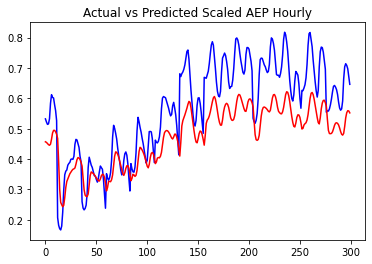

In [153]:
plt.title('Actual vs Predicted Scaled AEP Hourly')
plt.plot(n_testing_output3_array, color='b')
plt.plot(n_testing_predict2_array2, color='r')
plt.show()

# Exercise 10 (10 points) Summary lessons learned from this lab regarding the design and implementation of RNN for time series prediction.

# Answer to Exercise 10:

When we create a time series model, we need to normalize the series if their scales are different, otherwise we may get wrong results. When combining two models, we can use consecutive sliding windows to convert two nested loops into a single loop, and then reducing the time complexity.